In [1]:
#importing nessecary libraries
#reading data from train.sv file into dataframe
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
data1 = pd.read_csv('train.csv')
data2 = data1[['energy']]
data2.index = pd.to_datetime(data1['datetime'])

In [2]:
#checking for missing data
missing_data = data2[data2.isnull().any(axis=1)]
data2['energy'].isnull().sum()

1900

In [3]:
msd = missing_data.fillna('1')

In [5]:
#exporting missing data to view different graphs in tableau for checking randomness of the missing data
pd.DataFrame(msd).to_csv("miss.csv")

In [6]:
df = data2.dropna()

In [7]:
#taking a part of the data to check for the best null value filling model
df = df.head(20000)
df2 = df.dropna()
import numpy as np
df = df2.replace(df2.sample(n = 1000), np.NaN)

In [8]:
df = df.assign(InterpolateLinear=df.energy.interpolate(method='linear'))


In [9]:

df = df.assign(InterpolateTime=df.energy.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.energy.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.energy.interpolate(method='cubic'))

In [10]:

df = df.assign(InterpolateSLinear=df.energy.interpolate(method='slinear'))
df = df.assign(InterpolateAkima=df.energy.interpolate(method='akima'))
df = df.assign(InterpolatePoly5=df.energy.interpolate(method='polynomial', order=5))
df = df.assign(InterpolateSpline3=df.energy.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.energy.interpolate(method='spline', order=4))

In [11]:
# imputing using the rolling average
df = df.assign(RollingMean=df.energy.fillna(df.energy.rolling(24,min_periods=1,).mean()))
# imputing using the rolling median
df = df.assign(RollingMedian=df.energy.fillna(df.energy.rolling(24,min_periods=1,).median()))

In [12]:
#imputing using knn
from sklearn.impute import KNNImputer as ki
kimp2 = ki(n_neighbors = 2)
df["knn"] = kimp2.fit_transform(df[['energy']])


In [13]:
#checking the r2score to see how different models peroformed
from sklearn.metrics import r2_score
results = [(method, r2_score(df2.energy, df[method])) for method in list(df)[1:]]
results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_df.sort_values(by='R_squared', ascending=False)

,Method,R_squared
6,InterpolatePoly5,0.9996990538772877
3,InterpolateCubic,0.9996943651457745
7,InterpolateSpline3,0.9996884512591644
2,InterpolateQuadratic,0.9996828225036153
5,InterpolateAkima,0.9995956071411695
1,InterpolateTime,0.9992104164906075
4,InterpolateSLinear,0.9992104164906075
0,InterpolateLinear,0.9991415497100428
8,InterpolateSpline4,0.9983077847560585
9,RollingMean,0.9546050271259222


In [3]:
#filling the missing data with polynomial model with order 5
data2['energy'] = data2.energy.interpolate(method='polynomial', order = 5)

<ipython-input-3-18a2039753e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['energy'] = data2.energy.interpolate(method='polynomial', order = 5)


In [71]:
data2.isnull().sum()

energy    0
dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

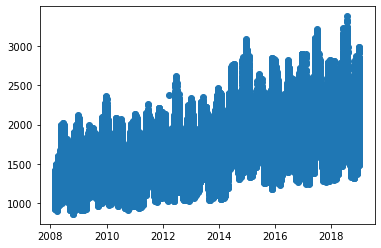

In [72]:
#plot the data to see its characteristics
import matplotlib.pyplot as plt
plt.scatter(data2.index,data2.energy.values)
plt.show

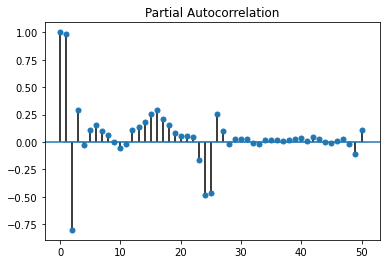

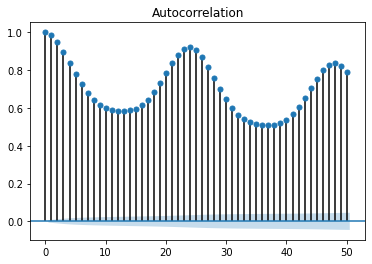

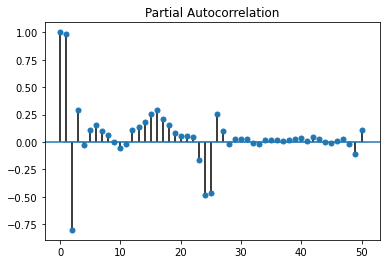

In [78]:
#acf and pacf plots are drawn to check for stationairty
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data2.energy)
plot_pacf(data2.energy)

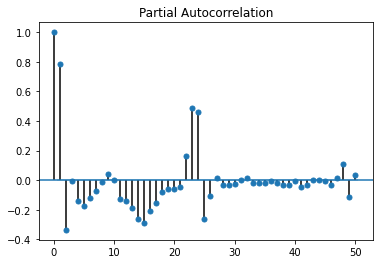

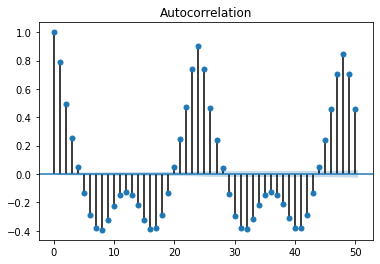

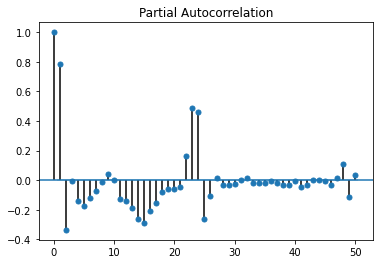

In [80]:
#acf and pacf plots of first diffference are drawn to check for stationairty
plot_acf(data2.diff().dropna().energy)
plot_pacf(data2.diff().dropna().energy)

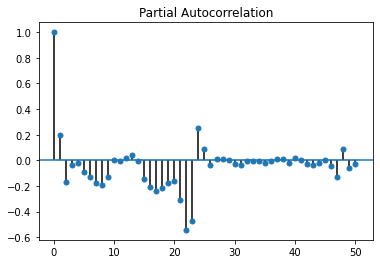

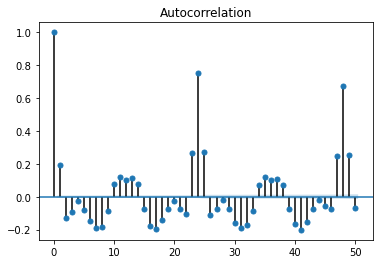

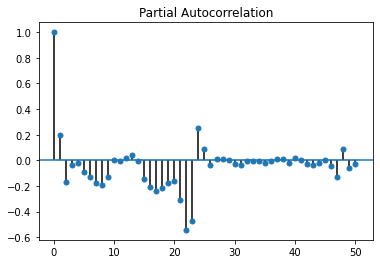

In [82]:
#acf and pacf plots of second difference are drawn to check for stationairty
plot_acf(data2.diff().diff().dropna().energy)
plot_pacf(data2.diff().diff().dropna().energy)

In [4]:
#spliting the data into train and test sets
X = data2.values
size = int(len(X)*0.75)
train, test = X[0:size], X[size:len(X)]
history = [i for i in train]

In [9]:
# fitting of the ARIMA model to the train dataset
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(history,order = (4,2,2))
model_fit = model.fit()

C:\Users\Anant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Anant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [30]:
#checking the summary of the model after fitting it to the train data
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                75993
Model:                 ARIMA(2, 2, 1)   Log Likelihood             -378617.482
Date:                Sun, 20 Nov 2022   AIC                         757242.963
Time:                        14:49:28   BIC                         757279.917
Sample:                             0   HQIC                        757254.318
                              - 75993                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0405      0.002    618.067      0.000       1.037       1.044
ar.L2         -0.3304      0.001   -292.406      0.000      -0.333      -0.328
ma.L1         -1.0000      0.003   -363.787      0.000      -1.005      -0.995
sigma2      1244.8800      3.033    410.409      0.000    1238.935    1250.825
===================================================================================
Ljung-Box (Q):                    56303.24   Jarque-Bera (JB):          43046974.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -1.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       119.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
#forecasting the values for the test data
forecast=model_fit.predict(start=len(train), end=94991, dynamic=False)

In [11]:
#calculating rmse for between test data and the forecast values
import math  
import sklearn.metrics
mse = sklearn.metrics.mean_squared_error(test, forecast)
rmse = math.sqrt(mse)
rmse

335.4002377163954

In [12]:
#forecasting the valeus for the orginal test dataset
predictresult = model_fit.predict(start=94993, end=121296, dynamic=True)

C:\Users\Anant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [14]:
#extracting the data
pd.DataFrame(predictresult).to_csv("results.csv")

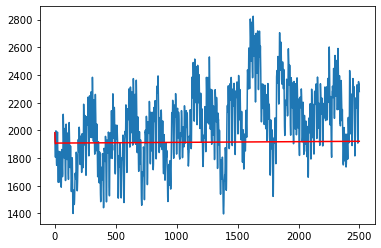

In [104]:
#plotting test valeus and forcast valeus to see how the model performed
plt.plot(test[0:2500])
plt.plot(forecast[0:2500], color = 'red')